### Can spectral bandpower features be discriminated for interictal and precital classes?

In [67]:
import numpy as np
import mne
from tqdm import tqdm
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import parallel_coordinates
import yasa

In [3]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/'
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']

/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.4.1, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = np.ones(data.shape[1])
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1 * np.ones(data.shape[1])
    return data, target

In [30]:
bands = [(0.1, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 70, 'Low Gamma'), (70, 127.9, 'High Gamma')]
print('Neural Rhythms')
bands

Neural Rhythms


[(0.1, 4, 'Delta'),
 (4, 8, 'Theta'),
 (8, 12, 'Alpha'),
 (12, 30, 'Beta'),
 (30, 70, 'Low Gamma'),
 (70, 127.9, 'High Gamma')]

In [61]:
# load preictal and interictal data
preictal_feature_list = []
interictal_feature_list = []
for i in tqdm(range(6)):
    # load preictal data
    p_filepath = root + case + preictal_filenames[i]
    p_data, _ = load_EEG(p_filepath, 'preictal')
    # generate preictal features
    preictal_df = yasa.bandpower(p_data, sf=256, win_sec=10, bands=bands, bandpass=True, relative=True)
    preictal_df = preictal_df[['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']]
#     preictal_features = preictal_df.to_numpy()
    # load interictal data
    ic_filepath = root + case + interictal_filenames[i]
    ic_data, _ = load_EEG(ic_filepath, 'interictal')
    # generate interictal features
    interictal_df = yasa.bandpower(ic_data, sf=256, win_sec=10, bands=bands, bandpass=True, relative=True)
    interictal_df = interictal_df[['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']]
#     interictal_features = interictal_df.to_numpy()
    # store data in list
#     preictal_feature_list.append(preictal_features)
#     interictal_feature_list.append(interictal_features)
    preictal_feature_list.append(preictal_df)
    interictal_feature_list.append(interictal_df)

100%|██████████| 6/6 [00:41<00:00,  6.90s/it]


In [72]:
preictal_feature_list[0].shape

(23, 7)

In [73]:
preictal_df.iloc[0]

Delta         0.568690
Theta         0.251177
Alpha         0.109174
Beta          0.066047
Low Gamma     0.006304
High Gamma    0.000435
Name: CHAN000, dtype: float64

### Sample 1

In [82]:
df_1 = pd.DataFrame(preictal_feature_list[0])
df_1['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_feature_list[0])
df_2['Interval'] = 'Interictal'
frames = [df_1, df_2]
rdf = pd.concat(frames)

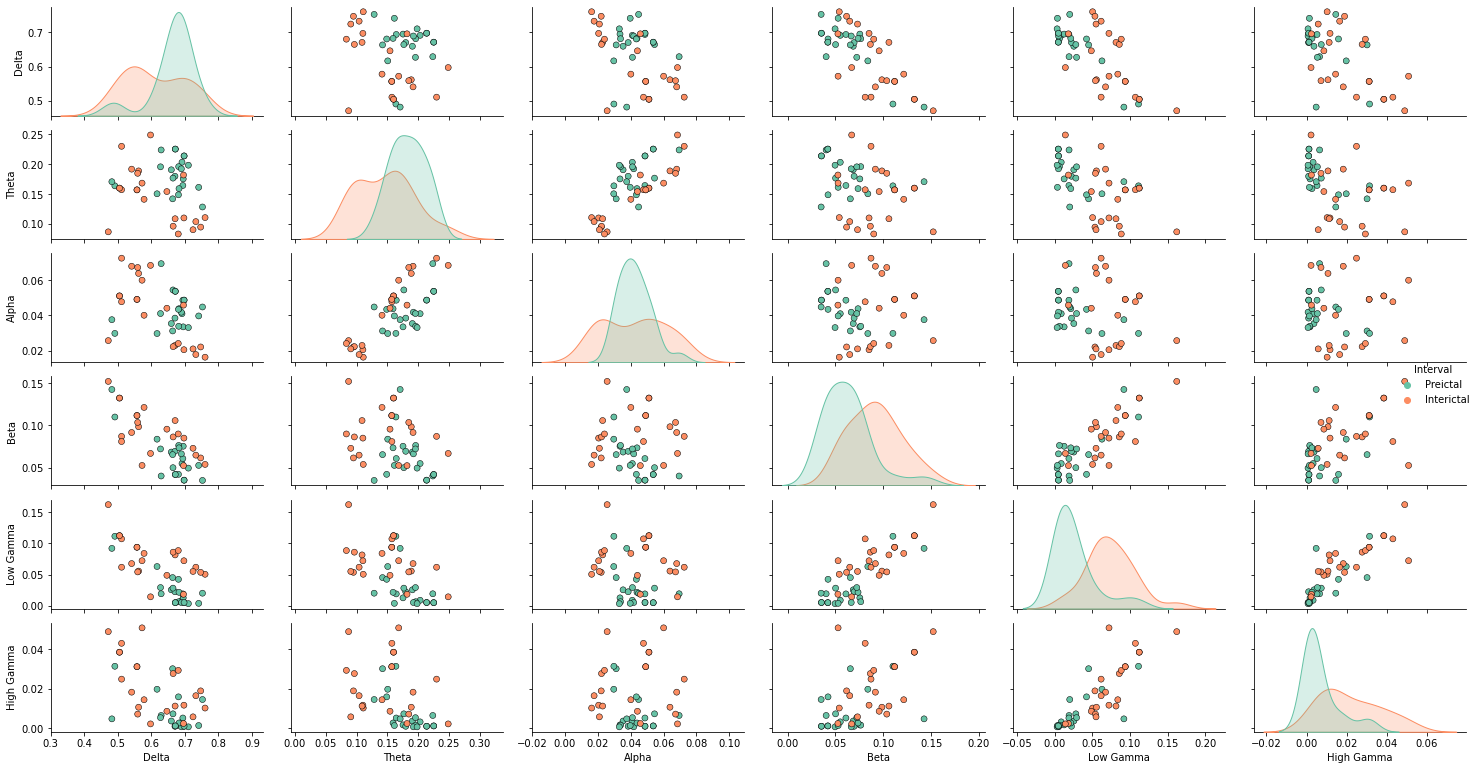

In [83]:
palette = sns.color_palette("Set2", n_colors=2)
sns.pairplot(rdf, hue='Interval', height=1.8, aspect=1.8, palette=palette,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))
plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/PIB_sample_distr.pdf')
plt.show()

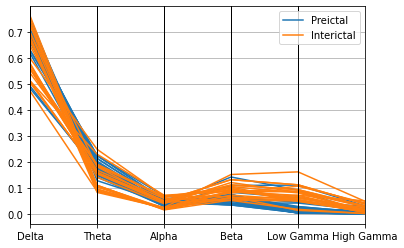

In [64]:
pc = parallel_coordinates(rdf, 'Interval', color=('tab:blue', 'tab:orange'))

Low gamma and high gamma seems to be giving the largest discriminatory ability.

### Sample 2

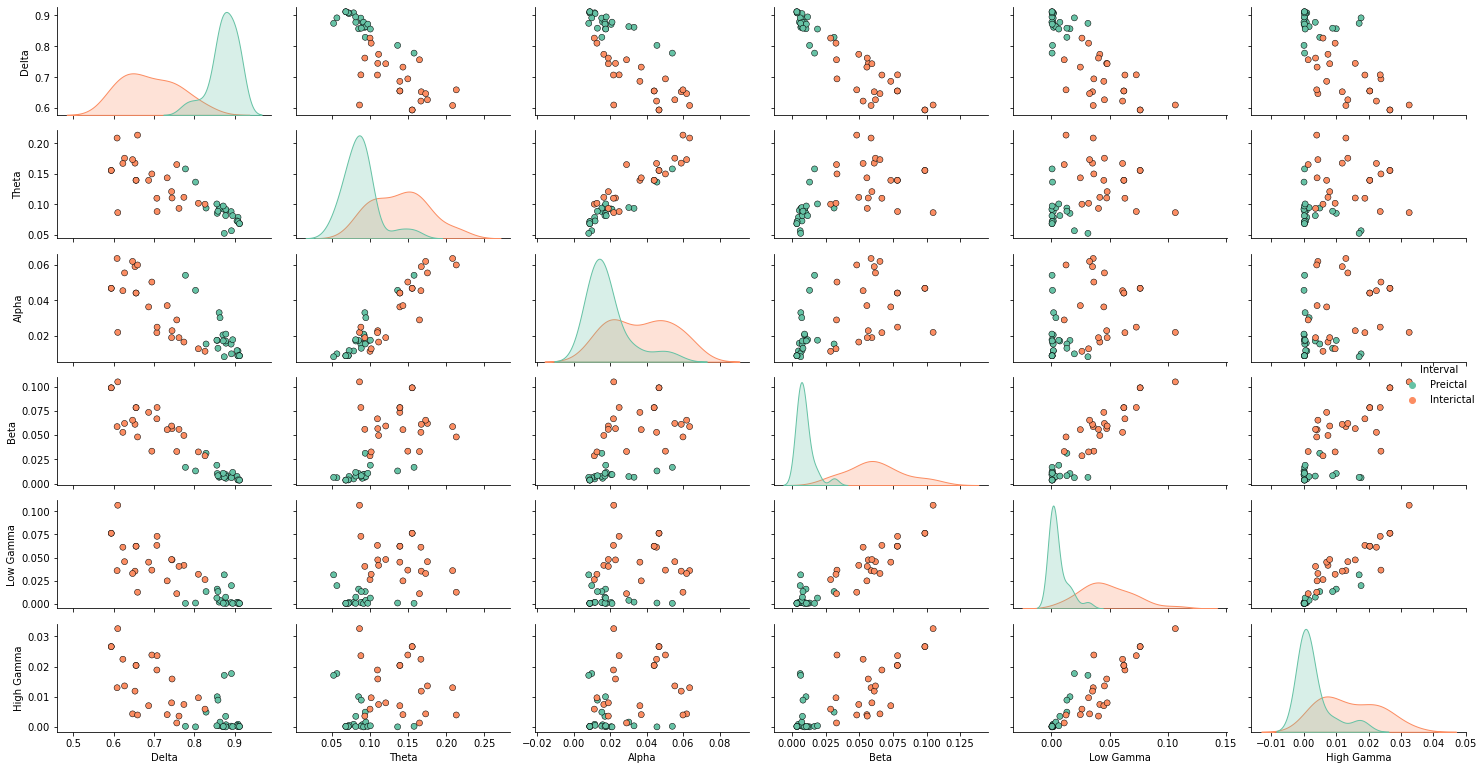

In [81]:
df_1 = pd.DataFrame(preictal_feature_list[2])
df_1['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_feature_list[2])
df_2['Interval'] = 'Interictal'
frames = [df_1, df_2]
rdf = pd.concat(frames)

palette = sns.color_palette("Set2", n_colors=2)
sns.pairplot(rdf, hue='Interval', height=1.8, aspect=1.8, palette=palette,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/PIB_sample_distr.pdf')
plt.show()

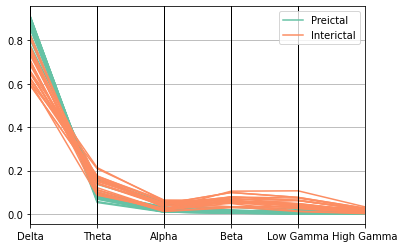

In [80]:
pc = parallel_coordinates(rdf, 'Interval', color=palette)
plt.show()

### Sample 3

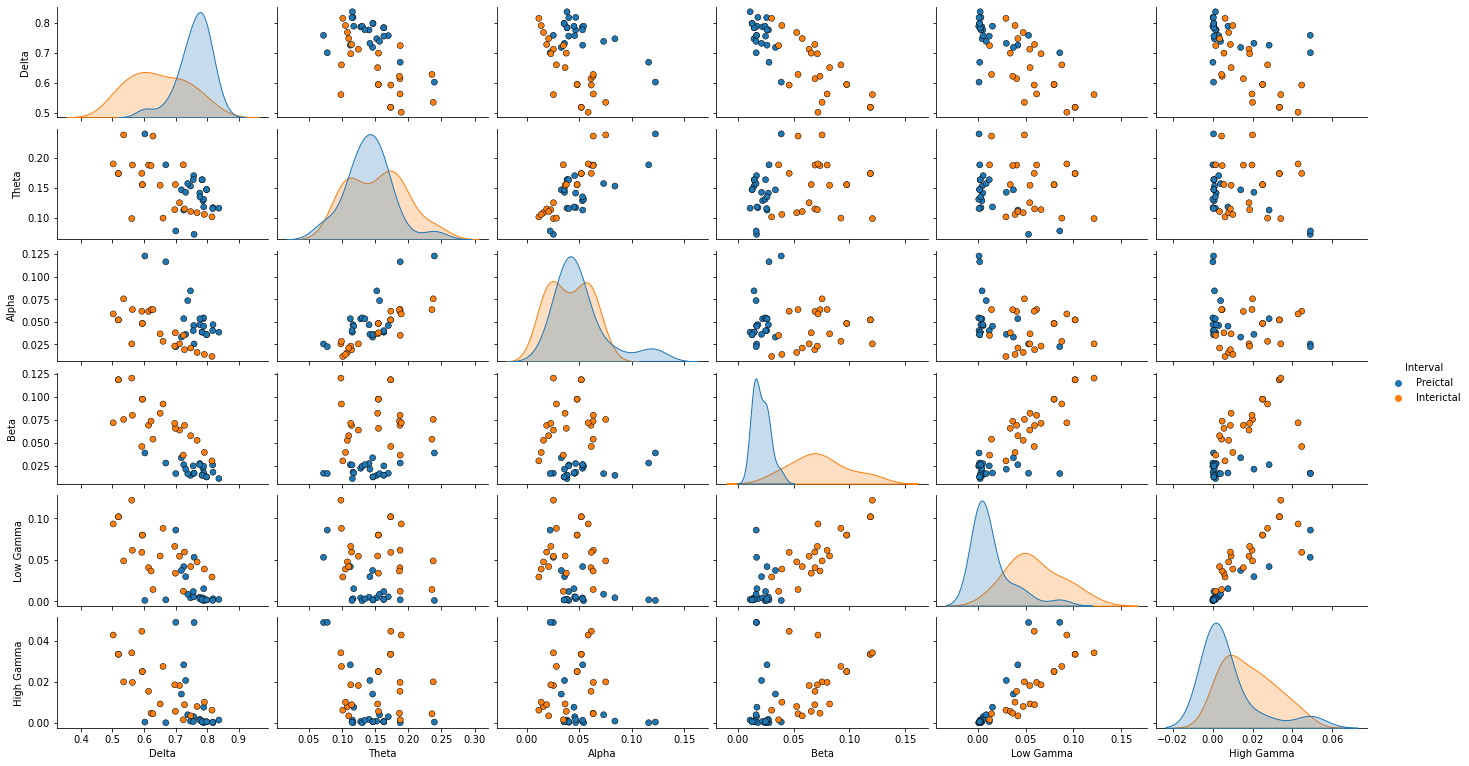

In [74]:
df_1 = pd.DataFrame(preictal_feature_list[3])
df_1['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_feature_list[3])
df_2['Interval'] = 'Interictal'
frames = [df_1, df_2]
rdf = pd.concat(frames)

sns.pairplot(rdf, hue='Interval', height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

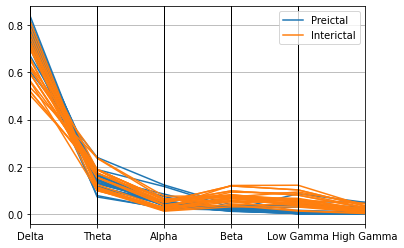

In [75]:
pc = parallel_coordinates(rdf, 'Interval', color=('tab:blue', 'tab:orange'))
plt.show()